# INF4480 Spring of 2021 - Project 3
### By Olav Fønstelien 2021-02-27
<br>

### Notes:
* Besides the lecure notes, I have mainly used the book _Statistical and Adaptive Signal Processing_ by Manolakis et. al. for this project
* Implementation in Python using NumPy, SciPy, matplotlib
* Generating slides from Jupyter Lab, and including most of the code since I myself think it is always interesting to see how things were done, and would also like feedback as well as tips and tricks
* The slides are in reveal.js format. Navigate by going right/left for Assignments 1-2-3 etc., and up/down for sub-assignments 1A-1B-1C etc.
* **NOTE: You may have to zoom out a bit to fit all content of each slide to your screen. I found that 60% worked well for me.**

## Introduction

In this assignment we will look at different estimators for the power spectral density (PSD) of the signal received by a sonar. More specifically,
* The _Periodogram_ estimator: A PSD estimator for the finite sequence $\{x(n)\}_0^{N-1}$ which all other methods discussed here are based upon
* The _Modified Periodogram_ estimator: A _windowed_ Periodogram, i.e. the Periodogram of the sequence $\{x(n) \cdot w(n)\}_0^{N-1}$, where $w(n)$ may be any window (_Hamming_, _Kaiser_, etc.). Windowing reduces spectrum leakage (bias), but comes at a cost to the spectrum resolution
* _Welch's_ estimator: A method which reduces estimator variance by fragmenting the sequence $\{x(n)\}_0^{N-1}$ and averaging the corresponding (modified) Periodograms
* _Multitaper_ estimator: A method which reduces variance by applying a selection of _orthogonal_ windows to the sequence $\{x(n)\}_0^{N-1}$ and averaging the Periodograms

Let's start by having a look at the data. We begin by setting up the environment...

In [1]:
### Setting up environment
import numpy as np
from scipy.io import loadmat
from scipy.signal import correlate, resample
from scipy.fft import fft
import matplotlib.pyplot as plt

### Setting plotting style
plt.style.use('fivethirtyeight')
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['pcolor.shading'] = 'flat'

The sonar recording is stored in a file ```sonardata.mat```. Let's first read this and look at it's content:

In [2]:
sonardata = loadmat('sonardata4.mat')
print('keys =', sonardata.keys())

keys = dict_keys(['__header__', '__version__', '__globals__', 'data', 'B', 'fs', 'fc', 'T_p'])


* ```data``` is the recorded (reflected) signal
* ```B``` is the sonar signal's bandwith
* ```fs``` is the sampling rate
* ```fc``` is the sonar signal's center frequency
* ```T_p``` is the pulse length

Let's allocate some variables to keep these values at hand

In [3]:
# Allocating variables
X = sonardata['data']
B = float(sonardata['B'])
fs = float(sonardata['fs'])
fc = float(sonardata['fc'])
Tp = float(sonardata['T_p'])
Nt, Nh = X.shape
print(f'B={B}, fs={fs}, fc={fc}, Tp={Tp}, Nt={Nt}, Nh={Nh}')

B=30000.0, fs=40000.0, fc=100000.0, Tp=0.003499, Nt=10000, Nh=32


In [4]:
frng = (-fs/2/1000+fc/1000, fs/2/1000+fc/1000)

Now, let's have a closer look at the ```data```.

First, we see that it has 10,000 samples on 32 channels, and that the signal is complex

In [5]:
X.shape, X[:5,0]

((10000, 32),
 array([ 3.0517578e-05+3.0517578e-05j, -3.0517578e-05-3.0517578e-05j,
         3.0517578e-05+3.0517578e-05j, -3.0517578e-05-3.0517578e-05j,
         3.0517578e-05+3.0517578e-05j], dtype=complex64))

In the assignment we will use channels 9 and 14. Plotting these we see that the "usual" assumptions of _ergodicity_ and _stationarity_ does not hold for these signals.
* Non-ergodicity means that we cannot use "ensemble" methods to achieve better performance for the spectral estimators
* Non-stationarity means that we can only estimate the power spectral density within limited ranges of the samples signals

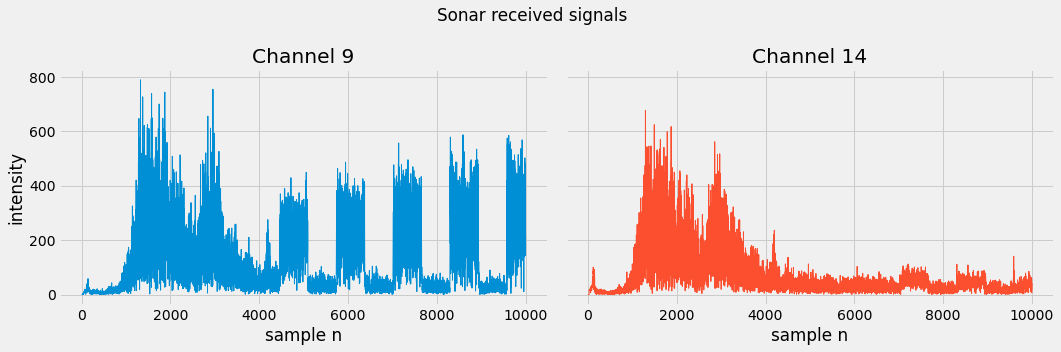

In [6]:
fig, axes = plt.subplots(ncols=2, nrows=1, sharex=True, sharey=True, figsize=(15,5))
fig.suptitle(r'Sonar received signals')

ax = axes[0]
ax.set_title('Channel 9')
ax.plot(np.abs(sonardata['data'][:,9]), lw=1)
ax.set_xlabel(r'sample n')
ax.set_ylabel(r'intensity')

ax = axes[1]
ax.set_title('Channel 14')
ax.plot(np.abs(sonardata['data'][:,14]), lw=1, color=COLORS[1])
ax.set_xlabel(r'sample n')

plt.tight_layout()
plt.show()

That we need the time series to be stationary follows from the definition of power spectral density;
$$
P_{xx}(e^{j \omega}) = \mathcal{F} \{ r_{xx}(l) \}
$$

meaning that $r_{xx}(l)$ can only vary depending on the lag, $l$.

Before we move on to the power spectral estimators, let's have a look at the ping signal pulse, which is given by the equation
$$
s(t) =  \bigg\{
    \begin{aligned}
    &\mathrm{exp}(j2 \pi \alpha t^2 / 2) \quad &&-T_p / 2 \le t \le T_p / 2\\
    &0 &&\text{otherwise}
    \end{aligned}
$$
where $\alpha = B/T_p$.

In [7]:
# Ping signal
Ns = int(Tp*fs)
alpha = B/Tp
ts = np.linspace(-Tp/2, Tp/2, Ns)
s = np.exp(1j*np.pi*alpha*ts**2)

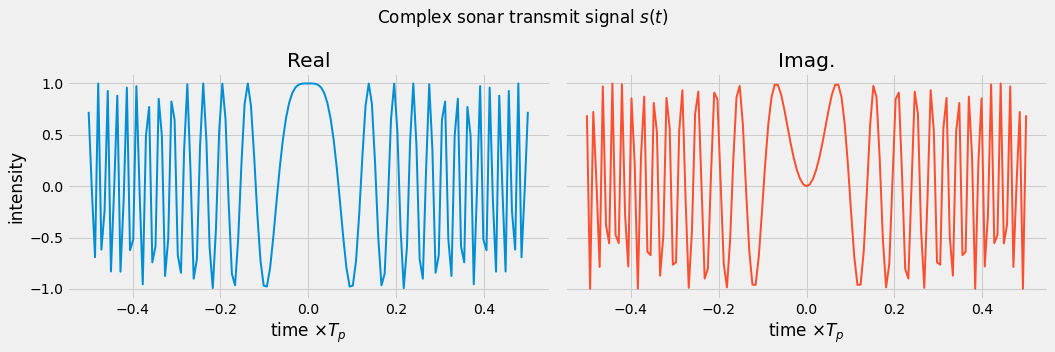

In [8]:
fig, axes = plt.subplots(ncols=2, nrows=1, sharex=True, sharey=True, figsize=(15,5))
fig.suptitle(r'Complex sonar transmit signal $s(t)$')

ax = axes[0]
ax.set_title('Real')
ax.plot(ts/Tp, np.real(np.exp(1j*np.pi*alpha*ts**2)), lw=2)
ax.set_xlabel(r'time $\times T_p$')
ax.set_ylabel(r'intensity')

ax = axes[1]
ax.set_title('Imag.')
ax.plot(ts/Tp, np.imag(np.exp(1j*np.pi*alpha*ts**2)), lw=2, color=COLORS[1])
ax.set_xlabel(r'time $\times T_p$')

plt.tight_layout()
plt.show()

In Project 2 we saw that we could filter out (some of) the noise in the received signal by _matched filtering_. We will reuse the code for that in this project, too:

In [9]:
def matched_filtering(X, s):
    '''Performs matched filtering of X by s. X is the received signal of an array ordered by (channel, signal).'''
    xc = np.empty(X.shape, dtype=np.complex)
    for i, x in enumerate(X.T):
        xc[:,i] = correlate(x, s, mode='same')
    return xc

... and overwrite the stored signal with the match-filtered signal:

In [10]:
X = matched_filtering(X, s)

## Assignment 1 - Power Spectral Density Estimators

We will start by deriving the algorithm for the Periodogram, and then move on to the refinements of this, which are the Welch and Multitaper methods.

We saw above that the Power Spectral Density $P_{xx}(e^{j \omega})$ of the infinite sequence $\{x(n)\}_{-\infty}^{\infty}$ is defined as the discrete-time Fourier transform of $X(n)$'s autocorrelation -- that is;
$$
P_{xx}(e^{j \omega}) = \mathcal{F} \{ r_{xx}(l) \} = \mathcal{F} \{ x(n)*x^*(-n) \}
$$

We use the relations $\mathcal{F} \{ x(-n) \} = X(e^{-j \omega})$ and $\mathcal{F} \{ x^*(n) \} = X^*(e^{-j \omega})$ to show that
$$
\mathcal{F} \{ x(n)*x^*(-n) \} = X(e^{j \omega}) \cdot X^*(e^{j \omega}) = |X(e^{j \omega})|^2
$$

Thus, the power spectral density function is given as
$$
P_{xx}(e^{j \omega}) = |X(e^{j \omega})|^2
$$

In practice, any sampled sequence must must have finite length. The Periodogram $\hat{P}_{xx}(e^{j \omega})$ is an estimator for the PSD for the fragment $\{x_w(n)\}_{0}^{N-1}$ of the infinite sequence $\{x(n)\}_{-\infty}^{\infty}$. The Periodogram is a periodic and continuous function in $\omega$ and is defined as
$$
\hat{P}_{xx}(e^{j \omega}) = \frac{1}{N} \mathcal{F} \{ x_w(n) \} = \frac{1}{N} |X_w(e^{j \omega})|^2
$$

To compute the Periodogram, we sample the continuous function $\hat{P}_{xx}(e^{j \omega})$ by computing the discrete Fourier transform $\tilde{X}_w(k)$ of $x_w(n)$, such that the DFT-based Periodogram becomes
$$
\tilde{P}_{xx}(k) = \frac{1}{N} |\tilde{X}_w(k)|^2 = P_{xx}(e^{-j2 \pi \frac{k}{N} }) \quad \text{where}  \quad k = 0,1,...,N-1
$$

Algorithmically, we arrive at the following work flow:
1. Compute the DFT $\tilde{X}_w(k)$ of sequence $\{x_w(n)\}_{0}^{N-1}$ <br/>
    ```Xk = DFT(x)```

2. Take the absolute-square value of $\tilde{X}_w(k)$: <br/>
    ```X = ABS(X)``` <br/>
    ```X = X*X```
3. Divide by the sequence length $N$ to obtain the Periodogram \tilde{P}_{xx}(k) and return: <br/>
    ```N = LENGTH(x)```  <br/>
    ```Pxx = X/N```  <br/>
    ```RETURN Pxx```

Although Python provides us with an efficient implementation of the FFT in the SciPy module (see ```scipy.fft.fft```), it is always fun to implement things from scratch to see that there is no magic going on behind the scenes. We therefore begin by making a rudimentary "Slow Fourier Transform" function, ```sft()```. It will slow our code down, but NumPy offers array computation which runs in C++ space, so we will get by just fine. We also include an optional argument ```zero_pad``` to allow for zero padding, which gives us a finer sampling of the DTFT.

In [11]:
def sft(x, zero_pad=0):
    '''Implements the "Slow Fourier Transform". Discrete Fourier Transform for x; pads with a factor zero_pad.'''
    N = x.shape[0]
    
    # Apply zero padding
    if zero_pad:
        x = np.hstack((x, np.zeros(zero_pad*N)))
        N = x.shape[0]

    # Calculate DFT
    n = np.arange(N)
    k = n.reshape(-1,1)
    e = np.exp(-1j*2*np.pi/N*k*n)
    x_dft = (x*e).sum(axis=1)
    
    # Rearrange around center frequency
    x_dft_left, x_dft_right = x_dft[N//2:], x_dft[:N//2]
    x_dft = np.hstack((x_dft_left, x_dft_right))
    
    return x_dft

To see that this works as it should, we test it on a simple sequence containing some known frequencies:

<StemContainer object of 3 artists>

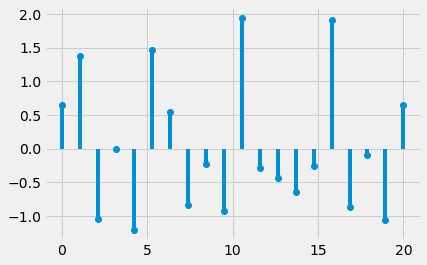

In [12]:
omega01 = 2*np.pi*.2
omega02 = 2*np.pi*.4
fsampler = 1.05
t = np.linspace(0, 20, int(20*fsampler/2)*2)
x = np.sin(omega01*t + .7) + np.sin(omega02*t)
plt.stem(t, x, basefmt=' ')

We run ```sft()``` twice -- once with the original $N$; and once with $10N$ zeros padded to the end of ```x```:

In [13]:
x_dft = sft(x)
x_dft_10x = sft(x, zero_pad=10)

Then we plot it and see that the original $N$-sample sequence alone is not enough to tell where the maxima are, but that the zero-padded sequence lets us identify two maxima -- one at around 0.21-0.23 Hz; and one around 0.43-0.45 Hz. Both are however somewhat off the true frequencies of 0.2 and 0.4 Hz, and zero-padding does not help us to correct that.

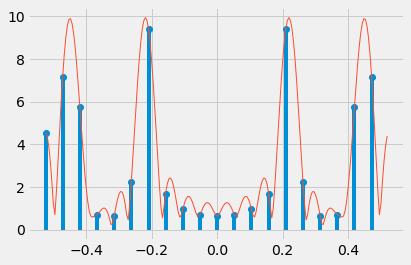

In [14]:
f = np.linspace(-fsampler/2, fsampler/2, len(x_dft), endpoint=False)
plt.stem(f, np.abs(x_dft), basefmt=' ')

f = np.linspace(-fsampler/2, fsampler/2, len(x_dft_10x), endpoint=False)
plt.plot(f, np.abs(x_dft_10x), lw=1)
plt.show()

To achieve better accuracy, we will have to increase the sampling of the original signal:

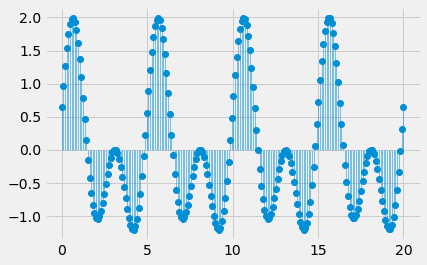

In [15]:
fsampler = 1.05*10
t = np.linspace(0, 20, int(20*fsampler/2)*2)
x = np.sin(omega01*t + .7) + np.sin(omega02*t)
_,stemlines,_ = plt.stem(t, x, basefmt=' ')
plt.setp(stemlines, 'linewidth', .5)
plt.show()

Now, calculating and plotting the DFT gives us a much better estimate:

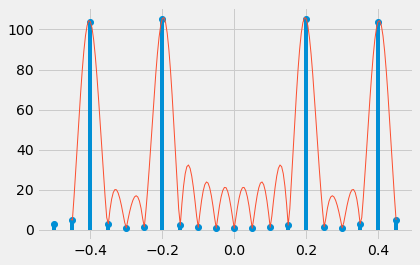

In [16]:
x_dft = sft(x)
N = len(x_dft)
f = np.linspace(-fsampler/2, fsampler/2, N, endpoint=False)
plt.stem(f[N//2-10:N//2+10], np.abs(x_dft[N//2-10:N//2+10]), basefmt=' ')

x_dft = sft(x, zero_pad=10)
N = len(x_dft)
f = np.linspace(-fsampler/2, fsampler/2, N, endpoint=False)
plt.plot(f[N//2-10*10:N//2+10*10], np.abs(x_dft[N//2-10*10:N//2+10*10]), lw=1)
plt.show()

The next step is then to step-by-step follow the recipe above to generate the Periodogram:
1. Compute the DFT $\tilde{X}_w(k)$ of sequence $\{x_w(n)\}_{0}^{N-1}$ <br/>
    ```Xk = DFT(x)```

2. Take the absolute-square value of $\tilde{X}_w(k)$: <br/>
    ```X = ABS(X)``` <br/>
    ```X = X*X```
3. Divide by the sequence length $N$ to obtain the Periodogram \tilde{P}_{xx}(k) and return: <br/>
    ```N = LENGTH(x)```  <br/>
    ```Pxx = X/N```  <br/>
    ```RETURN Pxx```

In [17]:
def periodogram(x, **kwargs):    
    '''Calculates the Periodogram'''
    N = x.shape[0]
    x = sft(x, **kwargs)
    x = np.abs(x)**2
    Pxx = x/N
    return Pxx

Now, let's have a look at the spectrogram of the double sine-function from above. Again, we calculate the spectra for the original series, and once for the zero-padded series and plot them on a dB scale. We see that the Spectrogram has the same limitations as the original DFT, with blurring due to spectral leakage (bias). But the side lobes have been attenuated to some degree due to the absolute-square operation.

In [18]:
fsampler = 1.05
t = np.linspace(0, 20, int(20*fsampler/2)*2)
x = np.sin(omega01*t + .7) + np.sin(omega02*t)

Pxx = periodogram(x)
Pxx_10x = periodogram(x, zero_pad=10)

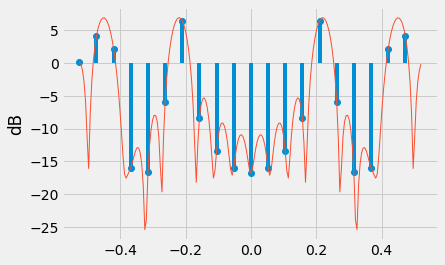

In [19]:
f = np.linspace(-fsampler/2, fsampler/2, len(Pxx), endpoint=False)
plt.stem(f, 10*np.log10(Pxx), basefmt=' ')

f = np.linspace(-fsampler/2, fsampler/2, len(Pxx_10x), endpoint=False)
plt.plot(f, 10*np.log10(Pxx_10x), lw=1)
plt.ylabel('dB')
plt.show()

Above we have calculated the Periodogram using the rectangular window. Next, we apply a spectral leakage-reducing (i.e. bias-reducing) window to the sequence $x(n)$ before we calculate the Periodogram, to generate what is called the Modified Periodogram. Again, Python provides windows in the standard scientific packages, but let's implement from scratch:

In [20]:
def window(N, n0=0, wN=None, wname='rectangular'):
    '''Returns a window sequence starting at n0, with window length N, and zero padding up to wN; Choose wname={'rectangular', 'hamming', 'hanning'}.'''
    assert wname in ['rectangular', 'hamming', 'hanning']
    if not wN:
        wN = N + n0

    w = np.zeros(wN)
    if wname == 'rectangular':
        w[n0:n0+N] = 1
    if wname == 'hamming':
        w[n0:n0+N] = .54 - .46*np.cos(2*np.pi*np.arange(N)/(N-1))
    if wname == 'hanning':
        w[n0:n0+N] = .5 - .5*np.cos(2*np.pi*np.arange(N)/(N-1))
    
    return w

This seems to produce the expected result:

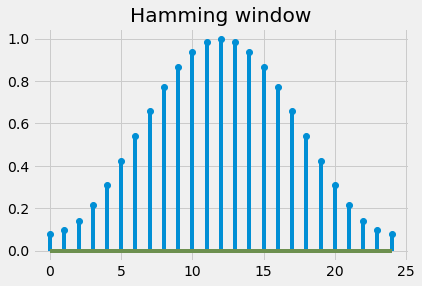

In [21]:
plt.stem(window(25, wname='hamming'))
plt.title('Hamming window')
plt.show()

And then let's update ```periodogram()``` to call the ```window()``` when we give it a keyword ```wname```:

In [22]:
def periodogram(x, normalize=False, wname=None, **kwargs):
    '''Estimates the Power Spectrum Density with the Periodogram method. Optional arguments are window wname={'rectangular', 'hamming', 'hanning'}.'''
    N = x.shape[0]
    
    # Apply window
    if wname is not None:
        w = window(N, wname=wname)
        x = x*w
    
    # Calculate Periodogram
    x = sft(x, **kwargs)
    x = np.abs(x)**2
    Pxx = x/N
    
    # Normalize around the mean of Pxx
    if normalize:
        Pxx = Pxx/Pxx.mean()
    
    return Pxx

Plotting the modified periodogram for the sine-series, we see that windowing gives us less biased estimates for the frequencies in the signal (spectral leakage reduced), but that this improvement comes at the cost of wider main lobes, and hence lower spectral resolution.

In [23]:
fsampler = 1.05
t = np.linspace(0, 20, int(20*fsampler/2)*2)
x = np.sin(omega01*t + .7) + np.sin(omega02*t)

Pxx = periodogram(x, wname='hamming', normalize=True)
Pxx_10x = periodogram(x, wname='hamming', normalize=True, zero_pad=10)

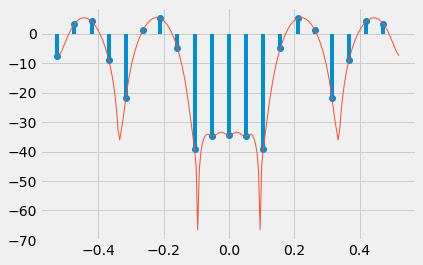

In [24]:
f = np.linspace(-fsampler/2, fsampler/2, len(Pxx), endpoint=False)
plt.stem(f, 10*np.log10(Pxx), basefmt=' ')

f = np.linspace(-fsampler/2, fsampler/2, len(Pxx_10x), endpoint=False)
plt.plot(f, 10*np.log10(Pxx_10x), lw=1)
plt.show()

Next, let's look at Welch's method, which divides the sequence $\{x_w(n)\}_{0}^{N-1}$ into $K$ sections of length $L$, offset from each other by $D \le L$ samples (i.e. possibly overlapping). The PSD estimate is then calculated as the mean of the periodograms for each of the sections. The motivation for this is that the averaging reduces variance in the estimate.

Implementation of Welch's method:

In [25]:
def welch(x, L=None, D=None, normalize=False, **kwargs):
    '''Estimates the Power Spectrum Density with Welch's method. Periodogram length L, offset by D.'''
    N = x.shape[0]
    Pxx = list()
    
    # Set up the ranges for each periodogram
    if L is None:
        L = N//8
    if D is None:
        D = L//2
    K = (N-L)//D + 1
    
    # Calculate periodograms
    for i in range(K):
        pxx = periodogram(x[i*D:i*D+L], **kwargs)
        Pxx.append(pxx)
    Pxx = np.concatenate(Pxx).reshape(-1, pxx.shape[0])

    # Estimate PSD
    Pxx = Pxx.mean(axis=0)
    
    # Normalize around the mean of Pxx
    if normalize:
        Pxx = Pxx/Pxx.mean()
    
    return Pxx

Repeating the exercise with the sine-sequence from above, we see that Welch's method produces a smoother estimate, but that the method also is more data hungry than the periodogram. Thus, for short sequences Welch method is not suitable since it will give more biased estimates for the frequencies in the signal. But for longer sequences (several hundred samples) its variance-reducing capability is very useful, as we will see further down.

In [26]:
fsampler = 1.05
t = np.linspace(0, 20, int(20*fsampler/2)*2)
x = np.sin(omega01*t + .7) + np.sin(omega02*t)

L = 10
Pxx = welch(x, L=L, wname='hamming', normalize=True)
Pxx_10x = welch(x, L=L, wname='hamming', normalize=True, zero_pad=10)

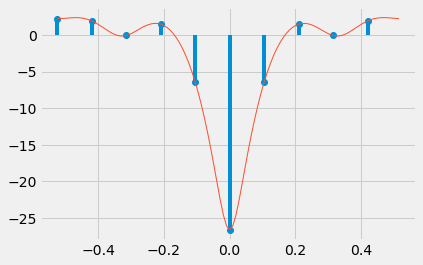

In [27]:
f = np.linspace(-fsampler/2, fsampler/2, len(Pxx), endpoint=False)
_,stemlines,_ = plt.stem(f, 10*np.log10(Pxx), basefmt=' ')

f = np.linspace(-fsampler/2, fsampler/2, len(Pxx_10x), endpoint=False)
plt.plot(f, 10*np.log10(Pxx_10x), lw=1)
plt.show()

Lastly, let's investigate the Multitaper method. Just like Welch's method, the multitaper method is based on averaging of periodograms, but in stead of segmenting the original sequence, it calculates periodograms for the whole sequence $\{x_w(n)\}_{0}^{N-1}$ using multiple _tapers_, or windows. The precondition for this to work is that the windows be orthogonal, such that they extract separate data from the sequence during the windowing process. 

The [spectrum](https://pyspectrum.readthedocs.io/en/latest/_modules/spectrum/mtm.html) module in Python provides a function ```dpss()``` which generates a set of orthogonal windows for us, and the module also provides a function ```mtm()``` which calculates the periodogram. However, implementing the multitapering algorithm is quite simple, and a set of "poor-man's windows" are also possible to construct from the equation
$$
w_k(n) = \sqrt{\frac{2}{N+1}} \sin \frac{\pi (k+1) (n+1)}{N+1}
$$


Plotting the three first poor-man's windows; $k=0,1,2$
$$
w_k(n) = \sqrt{\frac{2}{N+1}} \sin \frac{\pi (k+1) (n+1)}{N+1}
$$

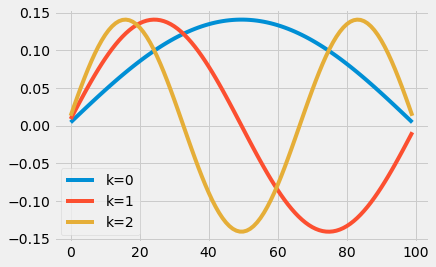

In [28]:
# Some poor-man windows
N, K = 100, 3
n = np.arange(N)
k = np.arange(K).reshape(-1,1)
W = np.sqrt(2/(N+1))*np.sin(np.pi*(k+1)*(n+1)/(N+1))
plt.plot(W.T)
plt.legend(('k=0', 'k=1', 'k=2'))

Implementation of the Multitaper method:

In [29]:
def multitaper(x, K=8, normalize=False, **kwargs):
    '''Estimates the Power Spectrum Density with the Multi-Taper method, using "poor-man's" tapers.'''
    N = x.shape[0]
    Pxx = list()
    
    # Calculate the poor-man tapers
    n = np.arange(N)
    k = np.arange(K).reshape(-1,1)
    W = np.sqrt(2/(N+1))*np.sin(np.pi*(k+1)*(n+1)/(N+1))
    
    # Calculate periodograms
    for i in range(K):
        w = W[i,:]
        pxx = periodogram(x*w, **kwargs)
        Pxx.append(pxx)
    Pxx = np.concatenate(Pxx).reshape(-1, pxx.shape[0])

    # Estimate PSD
    Pxx = Pxx.mean(axis=0)
    
    # Normalize around the mean of Pxx
    if normalize:
        Pxx = Pxx/Pxx.mean()
    
    return Pxx

Again, we plot the sine-sequence PSD estimate with the Miltitaper method. We see that the peaks are clearer defined and less biased than for Welch's method, and since we use the whole sequence, $\{x_w(n)\}_{0}^{N-1}$, spectral resolution is not hurt in the same way as for Welch.

In [30]:
fsampler = 1.05
t = np.linspace(0, 20, int(20*fsampler/2)*2)
x = np.sin(omega01*t + .7) + np.sin(omega02*t)

K = 2
Pxx = multitaper(x, K=K, normalize=True)
Pxx_10x = multitaper(x, K=K, zero_pad=10, normalize=True)

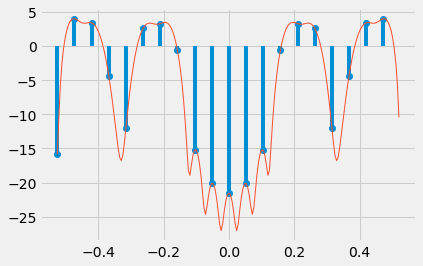

In [31]:
f = np.linspace(-fsampler/2, fsampler/2, len(Pxx), endpoint=False)
plt.stem(f, 10*np.log10(Pxx), basefmt=' ')

f = np.linspace(-fsampler/2, fsampler/2, len(Pxx_10x), endpoint=False)
plt.plot(f, 10*np.log10(Pxx_10x), lw=1)
plt.show()

### Ex. 1A - Estimators Applied on a Stationary Signal

Let's now finally move on to analysing some real data. We extract a section of samples from channel 14 where the signal is seemingly stationary (WSS), and investigate how each of our PSD estimators perform.

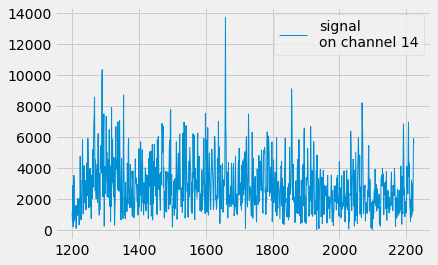

In [32]:
channel = 14
M, N = 1200, 1024
x = X[M:M+N, channel]
plt.plot(np.arange(M,M+N), np.abs(x), lw=1, label='signal\non channel 14')
plt.legend()
plt.show()

We begin with the **Periodogram**. The sonar has a bandidth of $B = 30$ kHz around its center frequency $f_c = 100$ kHz.
* We see that in the Modified periodogram, the damping that we achieve by applying a Hamming window reduces the spectral leakage (bias reduction), but the frequency response outside the 30 kHz bandwith still is significant due to spectral leakage (side lobe peaks are always greater than zero).
* As we would expect, variance is not affected significantly by windowing and we also see that spectral resolution still is satisfatory.
* From the modified spectrogram we estimate the true bandwidth to be $B \approx 25$ kHz

In [33]:
Pxx_rect = periodogram(x, normalize=True)
Pxx_hm = periodogram(x, normalize=True, wname='hamming')

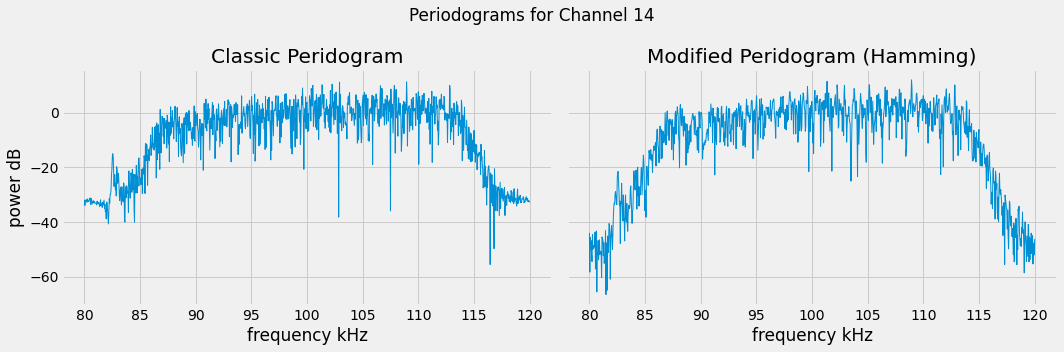

In [34]:
fig, axes = plt.subplots(ncols=2, nrows=1, sharex=True, sharey=True, figsize=(15,5))
fig.suptitle(r'Periodograms for Channel 14')

f = np.linspace(*frng, Pxx_rect.shape[0])

ax = axes[0]
ax.set_title('Classic Peridogram')
ax.plot(f, 10*np.log10(Pxx_rect), lw=1)
ax.set_xlabel(r'frequency kHz')
ax.set_ylabel(r'power dB')

ax = axes[1]
ax.set_title('Modified Peridogram (Hamming)')
ax.plot(f, 10*np.log10(Pxx_hm), lw=1)
ax.set_xlabel(r'frequency kHz')

plt.tight_layout()
plt.show()

**Welch's Method** with $K=7$ overlapping sections of the sequence $\{x_w(n)\}_{0}^{1023}$ to the left, and $K=15$ to the right.
* We saw above that Welch's method is "data hungry". In this application, we have enough to split the data into sections and get reasonable results, but that we have a cost to frequency response outside of the passband of about 10 dB (one order of magnitude)
* As for the periodogram, applying a Hamming window improves the damping outside the passband (bias reduction)
* Variance is greatly reduced, as expected, but at the cost of increased bias
* From the Hamming-windowed PSD we estimate the true bandwidth to be $B \approx 27$ kHz, slightly improved relative to the modified periodogram 

In [35]:
L, D = 256, 128
Pxx_rect = welch(x, L=L, D=D, normalize=True)
Pxx_hm = welch(x, L=L//2, D=D//2, normalize=True, wname='hamming')

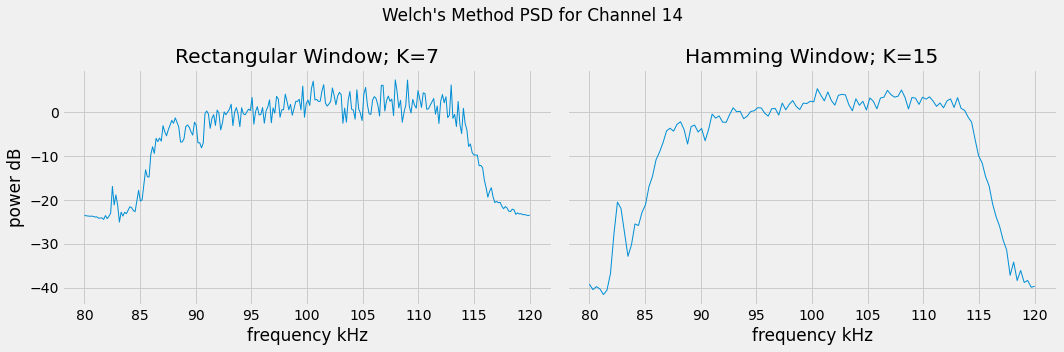

In [36]:
fig, axes = plt.subplots(ncols=2, nrows=1, sharex=True, sharey=True, figsize=(15,5))
fig.suptitle(r"Welch's Method PSD for Channel 14")

f = np.linspace(*frng, Pxx_rect.shape[0])

ax = axes[0]
ax.set_title('Rectangular Window; K=7')
ax.plot(f, 10*np.log10(Pxx_rect), lw=1)
ax.set_xlabel(r'frequency kHz')
ax.set_ylabel(r'power dB')

f = np.linspace(*frng, Pxx_hm.shape[0])
ax = axes[1]
ax.set_title('Hamming Window; K=15')
ax.plot(f, 10*np.log10(Pxx_hm), lw=1)
ax.set_xlabel(r'frequency kHz')

plt.tight_layout()
plt.show()

At last, we repeat the exercise for the **Multitaper Method** with $K=7$ and $K=15$ individual tapers (windows). We see that Multitaper combines the best of both the Periodogram and Welch's Method in that
* Frequency response outside the passband is similar in magnitude to that of the periodogram
* Variance is similar to that of Welch for similar number of periodograms
* From the 15-taper PSD we estimate the true bandwidth to be $B \approx 27$ kHz, similar to that of Welch 

In [37]:
Pxx_rect = multitaper(x, K=7, normalize=True)
Pxx_hm = multitaper(x, K=15, normalize=True)

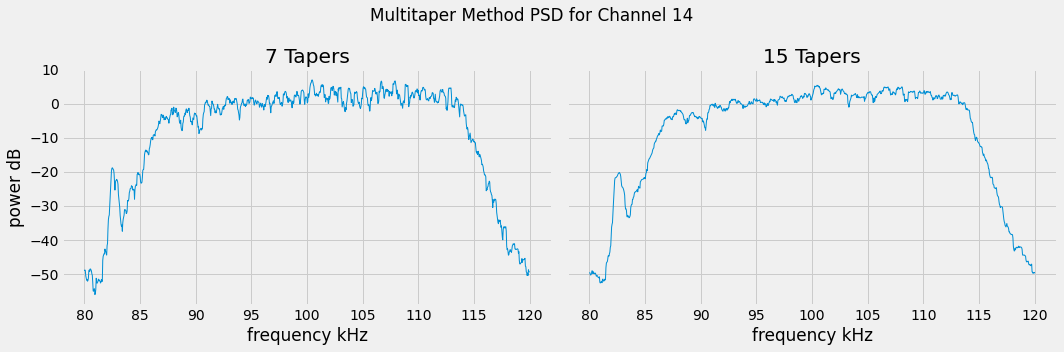

In [38]:
fig, axes = plt.subplots(ncols=2, nrows=1, sharex=True, sharey=True, figsize=(15,5))
fig.suptitle(r"Multitaper Method PSD for Channel 14")

f = np.linspace(*frng, Pxx_rect.shape[0])

ax = axes[0]
ax.set_title('7 Tapers')
ax.plot(f, 10*np.log10(Pxx_rect), lw=1)
ax.set_xlabel(r'frequency kHz')
ax.set_ylabel(r'power dB')

ax = axes[1]
ax.set_title('15 Tapers')
ax.plot(f, 10*np.log10(Pxx_hm), lw=1)
ax.set_xlabel(r'frequency kHz')

plt.tight_layout()
plt.show()

### Ex. 1B - Estimators Applied on a Non-Stationary Signal

In the introduction to Ex. 1 we saw that the power spectrum of a sequence $\{x(n)\}_{0}^{N-1}$ was defined as the DTFT of its autocorrelation, $\{r_{xx}(l)\}_{0}^{N-1}$, and that the autocorrelation may only be dependent of the lag, $l$, implying that the sequence must be stationary. We have just looked at how the PSD estimators perform on a stationary signal -- let's now see what happens when it isn't.

Channel 9 is non-stationary in the range range [7000, 2048]. Let's use this for our investigation. 

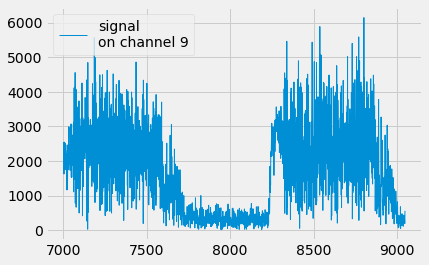

In [39]:
channel = 9
M, N = 7000, 2048
x = X[M:M+N, channel]
plt.plot(np.arange(M,M+N), np.abs(x), lw=1, label='signal\non channel 9')
plt.legend()
plt.show()

The **Periodogram** reveals what we will also see in the other estiamtes; additive noise from other sources makes the frequency response outside and inside the the passband (100$\pm$15 kHz) almost indestinguishable from each other. We see that
* Windowing has negligible effect on bias reduction; but
* Arguably some effect on variance reduction

In [40]:
Pxx_rect = periodogram(x, normalize=True)
Pxx_hm = periodogram(x, normalize=True, wname='hamming')

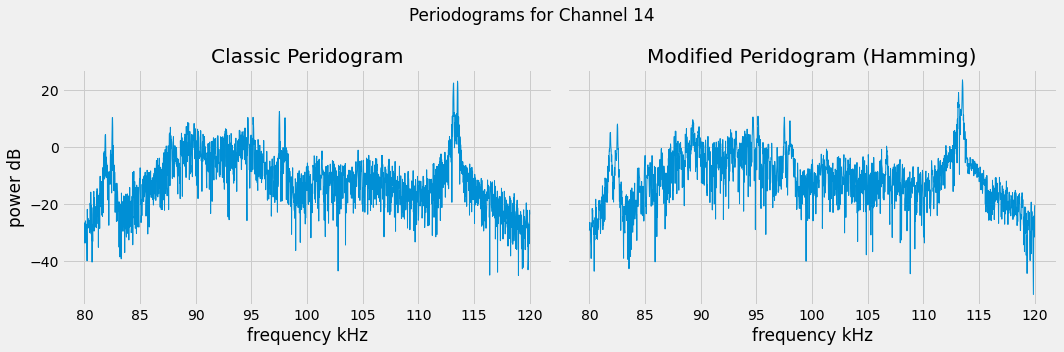

In [41]:
fig, axes = plt.subplots(ncols=2, nrows=1, sharex=True, sharey=True, figsize=(15,5))
fig.suptitle(r'Periodograms for Channel 14')

f = np.linspace(*frng, Pxx_rect.shape[0])

ax = axes[0]
ax.set_title('Classic Peridogram')
ax.plot(f, 10*np.log10(Pxx_rect), lw=1)
ax.set_xlabel(r'frequency kHz')
ax.set_ylabel(r'power dB')

ax = axes[1]
ax.set_title('Modified Peridogram (Hamming)')
ax.plot(f, 10*np.log10(Pxx_hm), lw=1)
ax.set_xlabel(r'frequency kHz')

plt.tight_layout()
plt.show()

For **Welch's Method** we see that
* Windowing has some effect on bias reduction, but that the bias is higher than for the Periodogram
* Averaging has good effect on variance reduction

In [42]:
L, D = 256, 128
Pxx_rect = welch(x, L=L, D=D, normalize=True)
Pxx_hm = welch(x, L=L//2, D=D//2, normalize=True, wname='hamming')

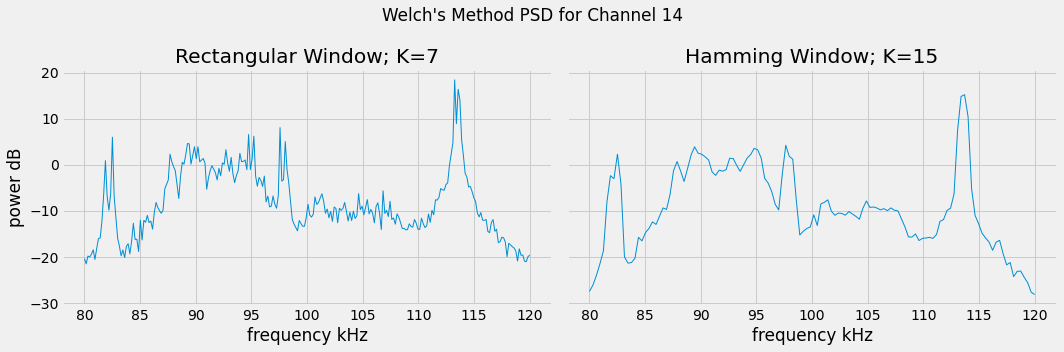

In [43]:
fig, axes = plt.subplots(ncols=2, nrows=1, sharex=True, sharey=True, figsize=(15,5))
fig.suptitle(r"Welch's Method PSD for Channel 14")

f = np.linspace(*frng, Pxx_rect.shape[0])

ax = axes[0]
ax.set_title('Rectangular Window; K=7')
ax.plot(f, 10*np.log10(Pxx_rect), lw=1)
ax.set_xlabel(r'frequency kHz')
ax.set_ylabel(r'power dB')

f = np.linspace(*frng, Pxx_hm.shape[0])
ax = axes[1]
ax.set_title('Hamming Window; K=15')
ax.plot(f, 10*np.log10(Pxx_hm), lw=1)
ax.set_xlabel(r'frequency kHz')

plt.tight_layout()
plt.show()

For the **Multitaper Method** we see that
* Bias is comparable to the Periodogram (better than Welch)
* Averaging has good effect on variance reduction

In [44]:
Pxx_rect = multitaper(x, K=7, normalize=True)
Pxx_hm = multitaper(x, K=15, normalize=True)

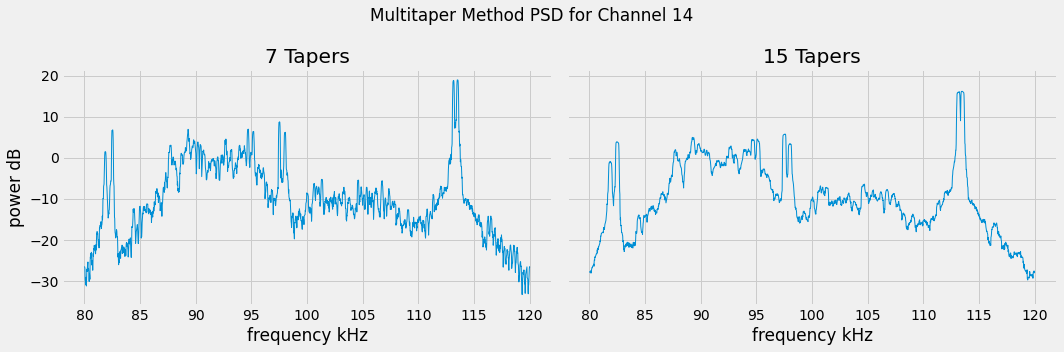

In [45]:
fig, axes = plt.subplots(ncols=2, nrows=1, sharex=True, sharey=True, figsize=(15,5))
fig.suptitle(r"Multitaper Method PSD for Channel 14")

f = np.linspace(*frng, Pxx_rect.shape[0])

ax = axes[0]
ax.set_title('7 Tapers')
ax.plot(f, 10*np.log10(Pxx_rect), lw=1)
ax.set_xlabel(r'frequency kHz')
ax.set_ylabel(r'power dB')

ax = axes[1]
ax.set_title('15 Tapers')
ax.plot(f, 10*np.log10(Pxx_hm), lw=1)
ax.set_xlabel(r'frequency kHz')

plt.tight_layout()
plt.show()

## Assignment 2 - Spectrogram Analysis - Short-Time Fourier Transform on a Non-Stationary Signal

One obvious solution to the problem of non-stationarity is to, if possible, divide the signal into sections where WSS can be assumed, and perform the PSD estimate on each section and present them in a _Spectrogram_. This process is called Short-Time Fourier Transform (STFT), which is what we will investigate in this exercise.

Implementing STFT is very simple -- it looks much the same as Welch's method; the only difference being that we do not keep only the average of all periodograms, but keep them all for presentation in a Spectrogram.

In [46]:
def spectrogram(x, L, D=None, normalize=False, fperiodogram=periodogram, fargs={}):
    '''Calculates the Spectrogram of x with estimates of its Power Spectrum Density in sequence lengths L, offset by D. The PSD is estimated using fperiodogram={periodogram, welch, multitaper} applied with arguments fargs.'''
    N = x.shape[0]
    Pxx = list()
    
    # Set shape of the Spectrogram
    if D is None:
        D = L
    K = (N-L)//D + 1

    # Calculate periodograms
    for i in range(K):
        pxx = fperiodogram(x[i*D:i*D+L], **fargs)
        Pxx.append(pxx)
    Pxx = np.concatenate(Pxx).reshape(-1, pxx.shape[0])
    
    # Normalize around the mean of Pxx
    if normalize:
        Pxx = Pxx/Pxx.mean(axis=1, keepdims=True)
    
    return Pxx

To see how the Spectrogram performs, we will first generate a non-stationary signal of known shape. This signal has a frequency which varies in time as a sine wave:

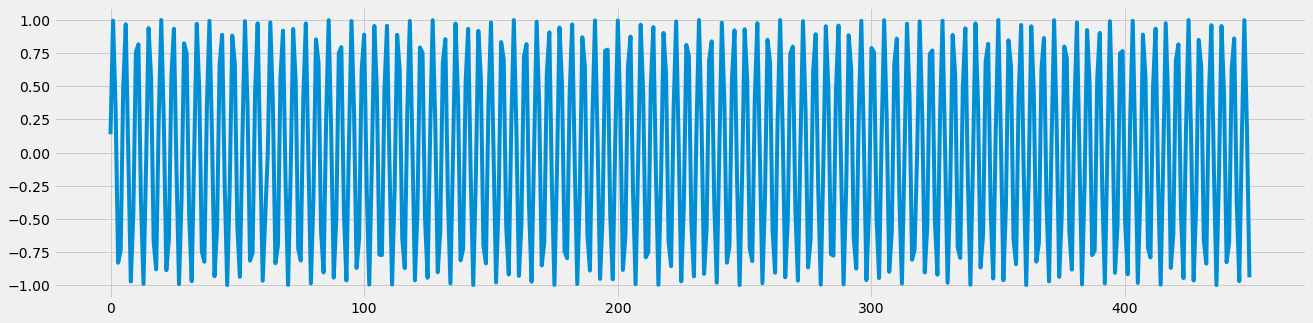

In [47]:
t = np.linspace(0,10,256)
x = np.sin(2*np.pi*(5 + 4*np.sin(2*np.pi*np.arange(1,129)/128)).reshape(-1,1)*t)
x = x.ravel()
plt.figure(figsize=(20,5))
plt.plot(x[450:900])
plt.show()

When generate the spectrograms, we have to decide which method to use for the PSD estimators. Below we see the result using the modified periodogram (Hamming), and multitaper with K=4. We see that multitapering reduces variance (less noise in the blue areas), but that the special windows seem to have wider main lobes than the Hamming window.

In [48]:
L = 256
Pxx_periodogram = spectrogram(x, L, fperiodogram=periodogram, fargs={'zero_pad':4, 'wname':'hamming'})
Pxx_multitaper = spectrogram(x, L, fperiodogram=multitaper, fargs={'zero_pad':4, 'K':4})

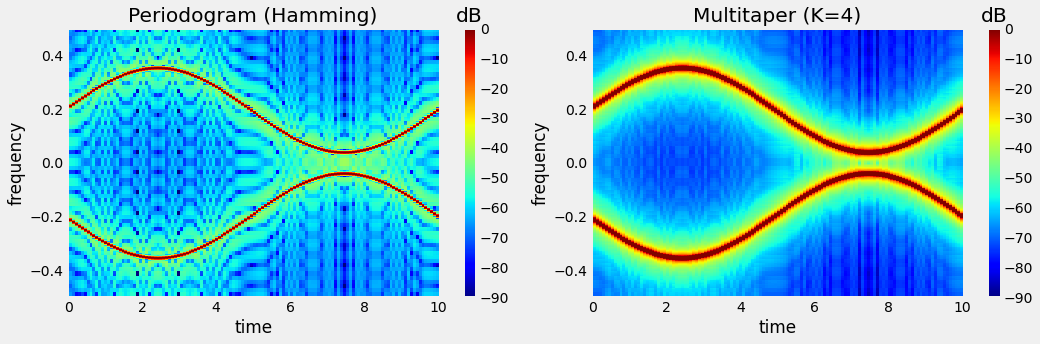

In [49]:
fig, axes = plt.subplots(ncols=2, nrows=1, sharex=True, sharey=False, figsize=(15,5))

Pxx_periodogram = Pxx_periodogram/Pxx_periodogram.max()
Pxx_multitaper = Pxx_multitaper/Pxx_multitaper.max()

D = L
K = (len(x)-L)//D + 1
t = np.linspace(0, 10, K)
f = np.linspace(-.5,.5, Pxx_periodogram.shape[1])
tt, ff = np.meshgrid(t,f)

ax = axes[0]
cm = ax.pcolormesh(tt, ff, 10*np.log10(Pxx_periodogram.T), shading='auto', cmap='jet', vmax=0, vmin=-90)
ax.set_title('Periodogram (Hamming)')
cbar = plt.colorbar(cm, ax=ax)
cbar.ax.set_title('dB')
ax.set_xlabel('time')
ax.set_ylabel('frequency')

ax = axes[1]
cm = ax.pcolormesh(tt, ff, 10*np.log10(Pxx_multitaper.T), shading='auto', cmap='jet', vmax=0, vmin=-90)
ax.set_title('Multitaper (K=4)')
cbar = plt.colorbar(cm, ax=ax)
cbar.ax.set_title('dB')
ax.set_xlabel('time')
ax.set_ylabel('frequency')

plt.tight_layout()
plt.show()

Let's now move back to real data.Below we see that the signal on channel 14 cannot be considered to be WSS outside the interval we studied in Ex. 1A. We will now study its properties in a spectrogram.

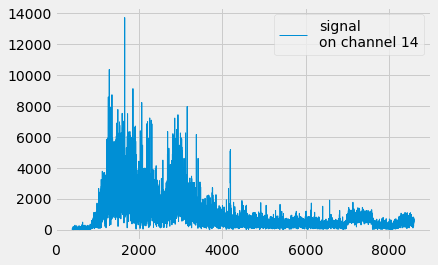

In [50]:
channel = 14
M, N = 400, 8192
x = X[M:M+N, channel]
plt.plot(np.arange(M,M+N), np.abs(x), lw=1, label='signal\non channel 14')
plt.legend()
plt.show()

**We begin with a coarse resolution** of $L=512$ non-overlapping sections (assume WSS in sections). We see that the step-wise variation along the section-axis is too high (up to 30-40 dB per step), so we first try to increase this.

In [51]:
L = 512
zero_pad = 0
Pxx = spectrogram(x, L, D=L, fperiodogram=periodogram, fargs={'zero_pad':zero_pad, 'wname':'rectangular'})
Pxx = Pxx/Pxx.max()

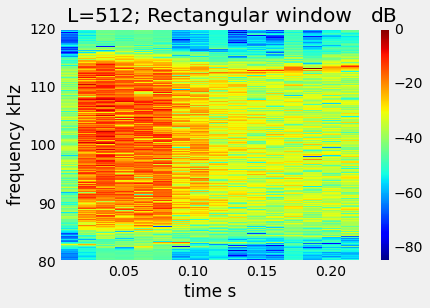

In [52]:
t0 = M/fs
t1 = (M+N)/fs
t = np.linspace(t0, t1, Pxx.shape[0])
f = np.linspace(*frng, Pxx.shape[1])
mg = np.meshgrid(t,f)

plt.title('L=512; Rectangular window')
plt.pcolormesh(*mg, 10*np.log10(Pxx.T), shading='auto', cmap='jet')
cbar = plt.colorbar()
cbar.ax.set_title('dB')
plt.xlabel('time s')
plt.ylabel('frequency kHz')
plt.show()

**Doubling the resolution** a few times we see that we arrive at ever better resoltution along the $t$-axis, but that this comes at a cost to the $f$-axis resolution, especially for $L=64$.

In [53]:
L1, L2, L3 = 256, 128, 64
zero_pad = 0
Pxx1 = spectrogram(x, L1, D=L1, fperiodogram=periodogram, fargs={'zero_pad':zero_pad, 'wname':'rectangular'})
Pxx2 = spectrogram(x, L2, D=L2, fperiodogram=periodogram, fargs={'zero_pad':zero_pad, 'wname':'rectangular'})
Pxx3 = spectrogram(x, L3, D=L3, fperiodogram=periodogram, fargs={'zero_pad':zero_pad, 'wname':'rectangular'})

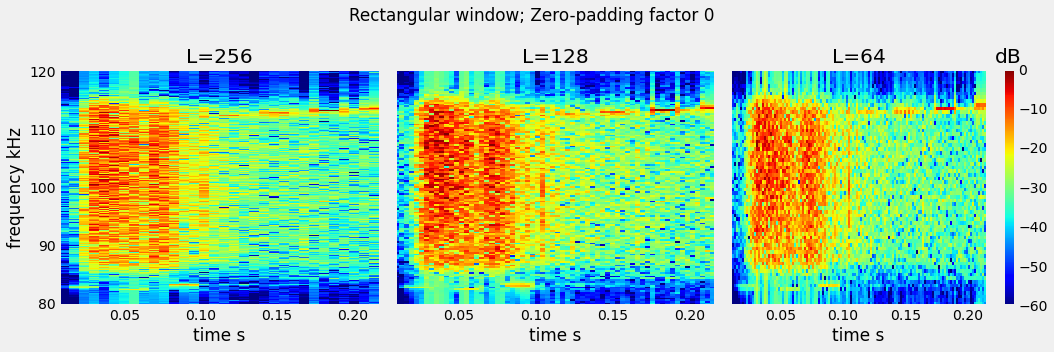

In [54]:
fig, axes = plt.subplots(ncols=3, nrows=1, sharex=False, sharey=True, figsize=(15,5))
fig.suptitle(r"Rectangular window; Zero-padding factor 0")

Pxx1, Pxx2, Pxx3 = Pxx1/Pxx1.max(), Pxx2/Pxx2.max(), Pxx3/Pxx3.max()
vmax, vmin = 0, -60
t0 = M/fs
t1 = (M+N)/fs

ax = axes[0]
t = np.linspace(t0, t1, Pxx1.shape[0])
f = np.linspace(*frng, Pxx1.shape[1])
mg = np.meshgrid(t,f)
ax.set_title('L=256')
ax.pcolormesh(*mg, 10*np.log10(Pxx1.T), shading='auto', cmap='jet', vmax=vmax, vmin=vmin)
ax.set_xlabel('time s')
ax.set_ylabel('frequency kHz')

ax = axes[1]
t = np.linspace(t0, t1, Pxx2.shape[0])
f = np.linspace(*frng, Pxx2.shape[1])
mg = np.meshgrid(t,f)
ax.set_title('L=128')
ax.pcolormesh(*mg, 10*np.log10(Pxx2.T), shading='auto', cmap='jet', vmax=vmax, vmin=vmin)
ax.set_xlabel('time s')

ax = axes[2]
t = np.linspace(t0, t1, Pxx3.shape[0])
f = np.linspace(*frng, Pxx3.shape[1])
mg = np.meshgrid(t,f)
ax.set_title('L=64')
cm = ax.pcolormesh(*mg, 10*np.log10(Pxx3.T), shading='auto', cmap='jet', vmax=vmax, vmin=vmin)
ax.set_xlabel('time s')

cbar = plt.colorbar(cm)
cbar.ax.set_title('dB')

plt.tight_layout()
plt.show()

**We improve spectral resolution** for the $L=64$ by letting the sections _overlap_. Setting $D=L/2$ approximately doubles the resolution alng the $t$-axis, while keeping the resolution along the $f$-axis. 
* In effect, $L=128$ becomes "the new $L=64$". 
* The poor spectral resolution at $L=64$ now becomes more evident, as well. 
* $L=128$ seems to give the best trade-off between resolution along both axes.

In [55]:
L1, L2, L3 = 256, 128, 64
D1, D2, D3 = L1//2, L2//2, L3//2
zero_pad = 0
Pxx1 = spectrogram(x, L1, D=D1, fperiodogram=periodogram, fargs={'zero_pad':zero_pad, 'wname':'rectangular'})
Pxx2 = spectrogram(x, L2, D=D2, fperiodogram=periodogram, fargs={'zero_pad':zero_pad, 'wname':'rectangular'})
Pxx3 = spectrogram(x, L3, D=D3, fperiodogram=periodogram, fargs={'zero_pad':zero_pad, 'wname':'rectangular'})

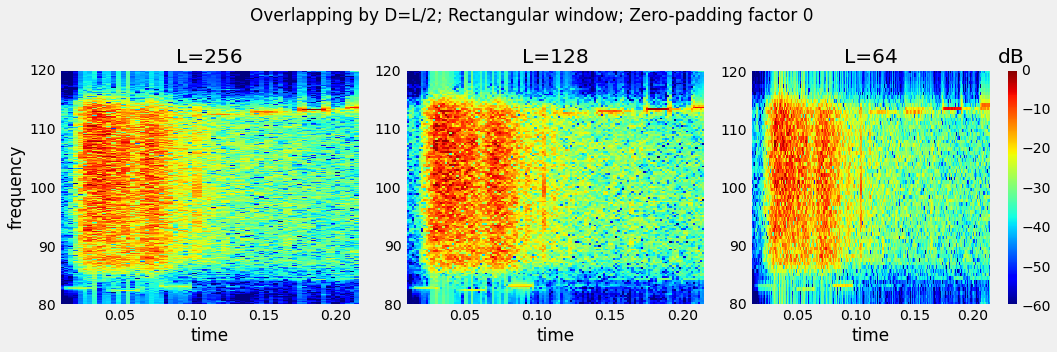

In [56]:
fig, axes = plt.subplots(ncols=3, nrows=1, sharex=False, sharey=False, figsize=(15,5))
fig.suptitle(r"Overlapping by D=L/2; Rectangular window; Zero-padding factor 0")

Pxx1, Pxx2, Pxx3 = Pxx1/Pxx1.max(), Pxx2/Pxx2.max(), Pxx3/Pxx3.max()
vmax, vmin = 0, -60
t0 = M/fs
t1 = (M+N)/fs

ax = axes[0]
t = np.linspace(t0, t1, Pxx1.shape[0])
f = np.linspace(*frng, Pxx1.shape[1])
mg = np.meshgrid(t,f)
ax.set_title('L=256')
ax.pcolormesh(*mg, 10*np.log10(Pxx1.T), shading='auto', cmap='jet', vmax=vmax, vmin=vmin)
ax.set_xlabel('time')
ax.set_ylabel('frequency')

ax = axes[1]
t = np.linspace(t0, t1, Pxx2.shape[0])
f = np.linspace(*frng, Pxx2.shape[1])
mg = np.meshgrid(t,f)
ax.set_title('L=128')
ax.pcolormesh(*mg, 10*np.log10(Pxx2.T), shading='auto', cmap='jet', vmax=vmax, vmin=vmin)
ax.set_xlabel('time')

ax = axes[2]
t = np.linspace(t0, t1, Pxx3.shape[0])
f = np.linspace(*frng, Pxx3.shape[1])
mg = np.meshgrid(t,f)
ax.set_title('L=64')
cm = ax.pcolormesh(*mg, 10*np.log10(Pxx3.T), shading='auto', cmap='jet', vmax=vmax, vmin=vmin)
ax.set_xlabel('time')


cbar = plt.colorbar(cm)
cbar.ax.set_title('dB')

plt.tight_layout()
plt.show()

**Windowing and zero padding**:
* Windowing to reduce the smearing/spectrum leakage along the $f$-axis; especially appearant in the upper and lower parts of the spectrogram. We choose a **Hamming** window
* Zero padding to make the appearance less grainy along the $f$-axis. We set zero padding to a **factor of 4**

In [57]:
L1, L2, L3 = 256, 128, 64
D1, D2, D3 = L1//2, L2//2, L3//2
zero_pad = 4
Pxx1 = spectrogram(x, L1, D=D1, fperiodogram=periodogram, fargs={'zero_pad':zero_pad, 'wname':'hamming'})
Pxx2 = spectrogram(x, L2, D=D2, fperiodogram=periodogram, fargs={'zero_pad':zero_pad, 'wname':'hamming'})
Pxx3 = spectrogram(x, L3, D=D3, fperiodogram=periodogram, fargs={'zero_pad':zero_pad, 'wname':'hamming'})

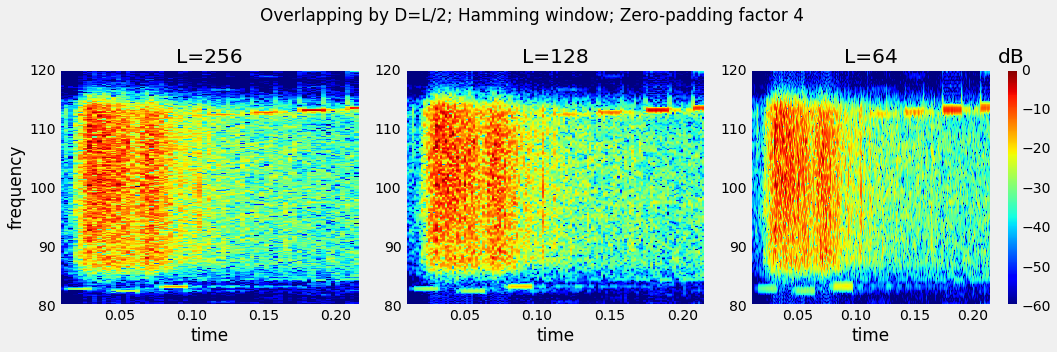

In [58]:
fig, axes = plt.subplots(ncols=3, nrows=1, sharex=False, sharey=False, figsize=(15,5))
fig.suptitle(r"Overlapping by D=L/2; Hamming window; Zero-padding factor 4")

Pxx1, Pxx2, Pxx3 = Pxx1/Pxx1.max(), Pxx2/Pxx2.max(), Pxx3/Pxx3.max()
vmax, vmin = 0, -60
t0 = M/fs
t1 = (M+N)/fs

ax = axes[0]
t = np.linspace(t0, t1, Pxx1.shape[0])
f = np.linspace(*frng, Pxx1.shape[1])
mg = np.meshgrid(t,f)
ax.set_title('L=256')
ax.pcolormesh(*mg, 10*np.log10(Pxx1.T), shading='auto', cmap='jet', vmax=vmax, vmin=vmin)
ax.set_xlabel('time')
ax.set_ylabel('frequency')

ax = axes[1]
t = np.linspace(t0, t1, Pxx2.shape[0])
f = np.linspace(*frng, Pxx2.shape[1])
mg = np.meshgrid(t,f)
ax.set_title('L=128')
ax.pcolormesh(*mg, 10*np.log10(Pxx2.T), shading='auto', cmap='jet', vmax=vmax, vmin=vmin)
ax.set_xlabel('time')

ax = axes[2]
t = np.linspace(t0, t1, Pxx3.shape[0])
f = np.linspace(*frng, Pxx3.shape[1])
mg = np.meshgrid(t,f)
ax.set_title('L=64')
cm = ax.pcolormesh(*mg, 10*np.log10(Pxx3.T), shading='auto', cmap='jet', vmax=vmax, vmin=vmin)
ax.set_xlabel('time')

cbar = plt.colorbar(cm)
cbar.ax.set_title('dB')

plt.tight_layout()
plt.show()

**Other PSD estimators** should give us the same benefints and problems here as we saw in Ex.1. Compared to the Spectrogram we see that
* **Welch** method is not suitable here since the number of samples in each section is too low. We get a smeared response along the $f$-axis which is not off-set by variance reduction
* **Multitaper** also reduces variance, but we see that the wider lobes of the special tapers compared to Hamming gives much the same problems with smearing as Welch
* We conclude that the **Modified Periodogram** gives the best result in this particular application

In [59]:
L = 128
zero_pad = 4
Pxx1 = spectrogram(x, L, D=L//2, fperiodogram=periodogram, fargs={'zero_pad':zero_pad, 'wname':'hamming'})
Pxx2 = spectrogram(x, L, D=L//2, fperiodogram=welch, fargs={'zero_pad':zero_pad, 'L':64, 'D':32, 'wname':'hamming'})
Pxx3 = spectrogram(x, L, D=L//2, fperiodogram=multitaper, fargs={'zero_pad':zero_pad, 'K':4})

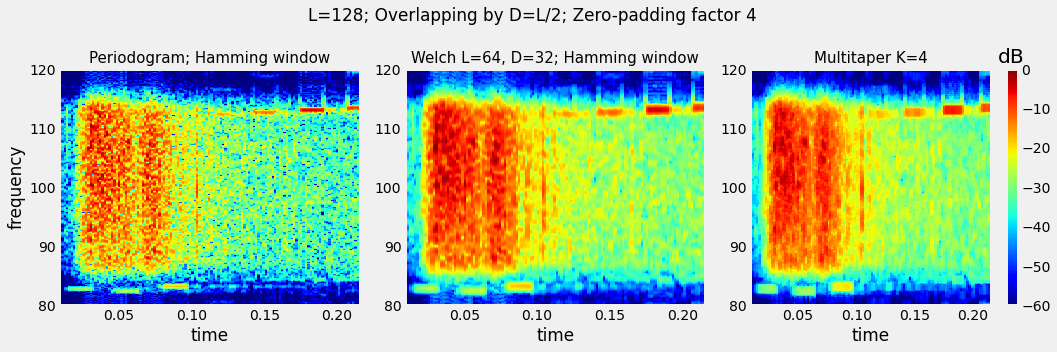

In [60]:
fig, axes = plt.subplots(ncols=3, nrows=1, sharex=False, sharey=False, figsize=(15,5))
fig.suptitle(r"L=128; Overlapping by D=L/2; Zero-padding factor 4")

Pxx1, Pxx2, Pxx3 = Pxx1/Pxx1.max(), Pxx2/Pxx2.max(), Pxx3/Pxx3.max()
vmax, vmin = 0, -60
t0 = M/fs
t1 = (M+N)/fs

ax = axes[0]
t = np.linspace(t0, t1, Pxx1.shape[0])
f = np.linspace(*frng, Pxx1.shape[1])
mg = np.meshgrid(t,f)
ax.set_title('Periodogram; Hamming window', fontsize=15)
ax.pcolormesh(*mg, 10*np.log10(Pxx1.T), shading='auto', cmap='jet', vmax=vmax, vmin=vmin)
ax.set_xlabel('time')
ax.set_ylabel('frequency')

ax = axes[1]
t = np.linspace(t0, t1, Pxx2.shape[0])
f = np.linspace(*frng, Pxx2.shape[1])
mg = np.meshgrid(t,f)
ax.set_title('Welch L=64, D=32; Hamming window', fontsize=15)
ax.pcolormesh(*mg, 10*np.log10(Pxx2.T), shading='auto', cmap='jet', vmax=vmax, vmin=vmin)
ax.set_xlabel('time')

ax = axes[2]
t = np.linspace(t0, t1, Pxx3.shape[0])
f = np.linspace(*frng, Pxx3.shape[1])
mg = np.meshgrid(t,f)
ax.set_title('Multitaper K=4', fontsize=15)
cm = ax.pcolormesh(*mg, 10*np.log10(Pxx3.T), shading='auto', cmap='jet', vmax=vmax, vmin=vmin)
ax.set_xlabel('time')

cbar = plt.colorbar(cm)
cbar.ax.set_title('dB')

plt.tight_layout()
plt.show()

Looking at the spectrogram, we see that it has some repeating fields in the lower left and upper right areas. These are chirps coming from other sensors in the sonar system.
* Duration of each chirp is about 12 ms, which does not correspond well to the defined chirp length $T_p = 3.5$ ms. We are possibly seeing chirps from several sensors being fired consequtively
* The chirp frequencies are grouped into bands around 83 and 112 kHz, with little variation

In [61]:
L = 128
D = L//2
zero_pad = 4
Pxx = spectrogram(x, L, D=D, fperiodogram=periodogram, fargs={'zero_pad':zero_pad, 'wname':'hamming'})
Pxx = Pxx/Pxx.max()

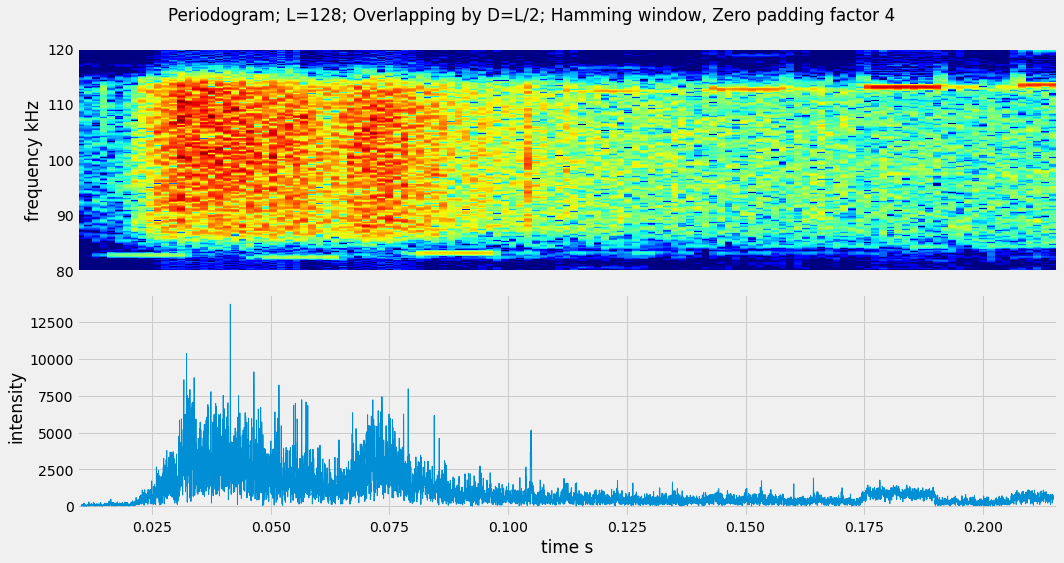

In [62]:
fig, axes = plt.subplots(ncols=1, nrows=2, sharex=True, sharey=False, figsize=(15,8))
fig.suptitle('Periodogram; L=128; Overlapping by D=L/2; Hamming window, Zero padding factor 4')

t0 = M/fs
t1 = (M+N)/fs

ax = axes[0]
t = np.linspace(t0, t1, Pxx.shape[0])
f = np.linspace(*frng, Pxx.shape[1])
mg = np.meshgrid(t,f)
cm = ax.pcolormesh(*mg, 10*np.log10(Pxx.T), shading='auto', cmap='jet', vmin=-60, vmax=0)
ax.set_ylabel('frequency kHz')

ax = axes[1]
t = np.linspace(t0, t1, x.shape[0])
ax.plot(t, np.abs(x), lw=1, label='signal\non channel 14')
ax.set_ylabel('intensity')
ax.set_xlabel('time s')

plt.tight_layout()
plt.show()